In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from sklearn.linear_model import SGDRegressor
from operator import itemgetter
from math import floor

%run -i ./Model_Eval.ipynb

In [2]:
training_data = pd.read_csv("../Training_Data/one_star_reviews_balanced.csv")
training_data.head(3)

,full_text,reviewer_avg_rating
0,it is very poor quality. The color looks like ...,4.000000
1,Poor quality Sticks and has excessive play loc...,2.777778
2,Was nice until they doubled the price I was ju...,2.222222


In [3]:
features = training_data['full_text']
labels = training_data['reviewer_avg_rating']

X_train, X_test, Y_train, Y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42)

In [4]:
def clean(text):
    wn = nltk.WordNetLemmatizer()
    stopword = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    lower = [word.lower() for word in tokens]
    no_stopwords = [word for word in lower if word not in stopword]
    no_alpha = [word for word in no_stopwords if word.isalpha()]
    lemm_text = [wn.lemmatize(word) for word in no_alpha]
    clean_text = lemm_text
    return clean_text

def vectorize(data,tfidf_vect_fit):
    X_tfidf = tfidf_vect_fit.transform(data)
    words = tfidf_vect_fit.get_feature_names_out ()
    X_tfidf_df = pd.DataFrame(X_tfidf.toarray())
    X_tfidf_df.columns = words
    return(X_tfidf_df)

In [5]:
tfidf_vect = TfidfVectorizer(analyzer=clean, max_features=6000)
tfidf_vect_fit=tfidf_vect.fit(X_train)

In [6]:
assert len(X_train) == len(Y_train)
x_train_len = len(X_train)
x_train_len

837062

In [7]:
# define training index chunks
training_index_chunks = []
chunk_count = 8
chunk_size = floor(x_train_len / chunk_count)

for i in range(0, chunk_count):
    training_index_chunks.append(
        list(range(i*chunk_size, (i+1) * chunk_size))
    )

In [8]:
sgdr = SGDRegressor()

In [9]:
epochs = 15
num_steps = epochs * chunk_count

# 10 training epochs, each with 8 training chunks. so 80 steps

tqdm._instances.clear()
pbar = tqdm(total=num_steps)

r2_scores = [] # keep track of the test r2 scores

last_score = None

for epoch in range(0,epochs):
    for chunk_num, training_index_chunk in enumerate(training_index_chunks):
        pbar.set_description(f"Epoch: {epoch}, training chunk: {chunk_num}, last score: {last_score}")
        
        # pull out chunks of training data
        X_train_chunk = itemgetter(*training_index_chunk)(list(X_train))
        Y_train_chunk = itemgetter(*training_index_chunk)(list(Y_train))
        
        # fit the X train text to the vectorize function
        X_train_vect = vectorize(X_train_chunk, tfidf_vect_fit)
        
        sgdr.partial_fit(X_train_vect, Y_train_chunk)
        pbar.update(1)
        
    # this score should be r2
    X_test_vect = vectorize(X_test, tfidf_vect_fit)
    last_score = sgdr.score(X_test_vect, Y_test)
    r2_scores.append(last_score)

Epoch: 14, training chunk: 7, last score: 0.039095320371089426: 100%|███████████████| 120/120 [1:59:47<00:00, 46.98s/it]

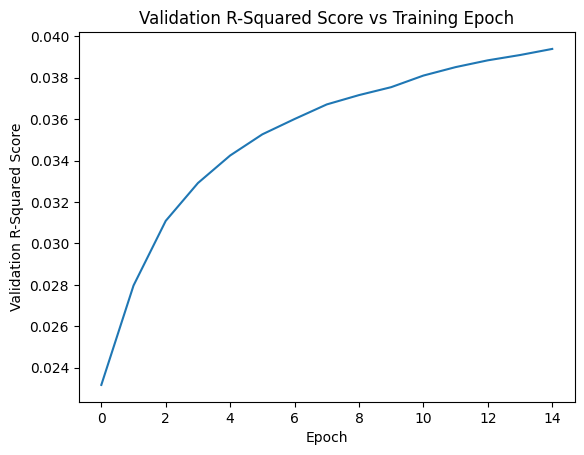

In [14]:
plt.plot(r2_scores)
plt.ylabel("Validation R-Squared Score")
plt.xlabel('Epoch')
plt.title('Validation R-Squared Score vs Training Epoch')
plt.show()

### Take a look at predicted vs actual for validation

In [16]:
X_test_vect = vectorize(X_test, tfidf_vect_fit)

In [17]:
Y_test_predictions = sgdr.predict(X_test_vect)

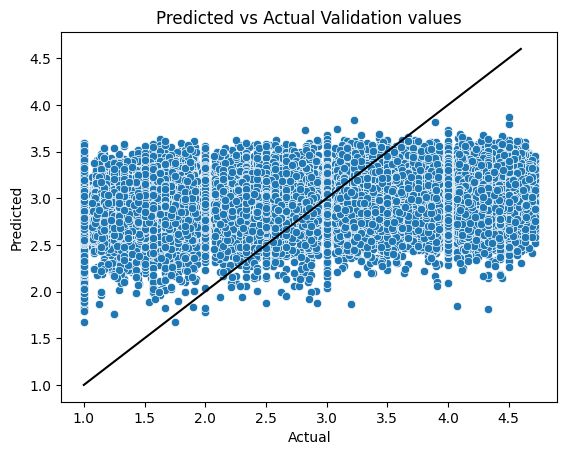

In [21]:
sns.scatterplot(x=Y_test, y=Y_test_predictions)
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title("Predicted vs Actual Validation values")
plt.plot([1,4.6], [1,4.6], color="black") # perfect line
plt.show()